## 1. Load Data and Exploratory Analysis

Load the dataset, separate features (X) from labels (y), and create pairplot

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv("exam_2021_01_15.csv")

# Separate features (X) and gold standard labels (y)
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last column

print("Dataset shape:", df.shape)
print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1000, 4)
Features (X) shape: (1000, 3)
Labels (y) shape: (1000,)

Feature columns: ['A0', 'A1', 'A2']

First few rows:


,A0,A1,A2,y
0,2067.582042,-15.259519,0.020472,2
1,1319.589579,-18.412320,0.521308,0
2,1170.212183,-19.470602,0.814986,0
3,1424.162191,9.867841,0.848751,1
4,1551.069098,11.809364,0.884964,1


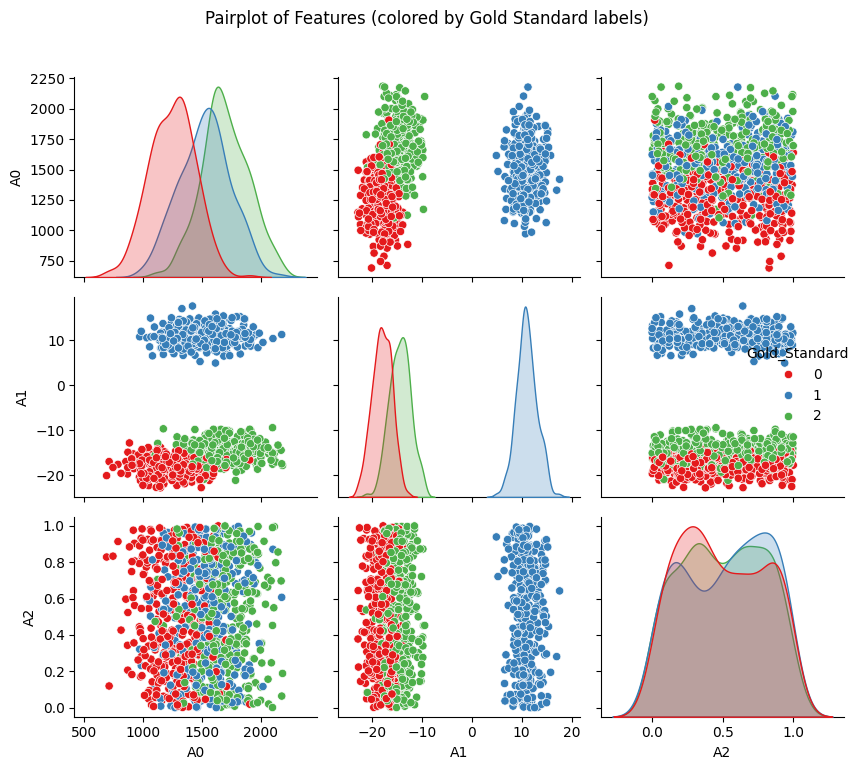

In [3]:
# Create pairplot to visualize relationships between features
# Add the gold standard labels for coloring
X_with_labels = X.copy()
X_with_labels['Gold_Standard'] = y

sns.pairplot(X_with_labels, hue='Gold_Standard', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Features (colored by Gold Standard labels)', y=1.02)
plt.tight_layout()
plt.show()

### Comments on Pairplot:

**Visual Observations:**
- The pairplot shows relationships between all feature pairs
- Colors represent the gold standard clusters from the dataset
- Diagonal plots show the distribution of each feature
- Off-diagonal plots show scatter plots between feature pairs

**Key Insights:**
- **Cluster Separation:** Check if clusters are well-separated in the feature space
- **Feature Scales:** Different features may have different scales (important for preprocessing)
- **Feature Correlations:** Some features may be correlated or redundant
- **Cluster Shapes:** Clusters may be spherical (good for K-means) or irregular (better for DBSCAN)
- **Overlap:** If clusters overlap significantly, clustering will be more challenging

**Implications for Clustering:**
- Well-separated clusters suggest good potential for unsupervised clustering
- Different scales may require normalization/scaling
- The number of visible clusters guides our choice of k

## 2. Find Best Clustering Scheme

Test different numbers of clusters and visualize silhouette scores

In [4]:
# Test KMeans with different numbers of clusters
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

k=2: Silhouette Score = 0.5683
k=3: Silhouette Score = 0.5347
k=4: Silhouette Score = 0.5405
k=5: Silhouette Score = 0.5134
k=6: Silhouette Score = 0.4936
k=7: Silhouette Score = 0.5166
k=8: Silhouette Score = 0.5123
k=9: Silhouette Score = 0.5084
k=10: Silhouette Score = 0.4998


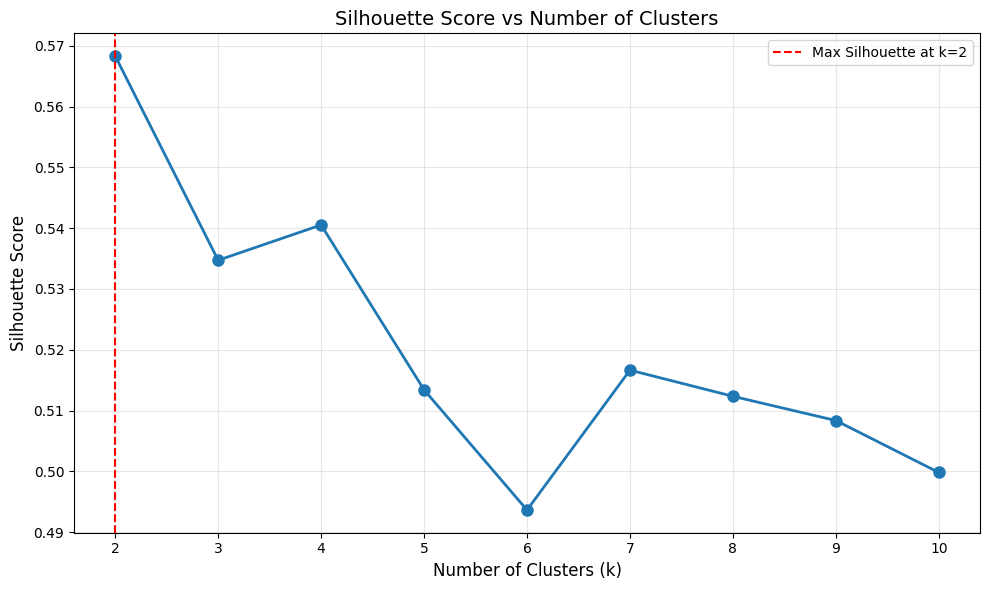


Best k based on silhouette score: 2
Best silhouette score: 0.5683


In [5]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Mark the best k based on silhouette score
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
plt.axvline(x=best_k_silhouette, color='r', linestyle='--', 
            label=f'Max Silhouette at k={best_k_silhouette}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest k based on silhouette score: {best_k_silhouette}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

### Visual Inspection and Final Choice

**Important Note:** Simple optimization of silhouette score is not enough.
We need to consider:
- The pairplot visualization showing actual cluster separation
- The gold standard has a specific number of clusters
- Domain knowledge and visual inspection

Based on the pairplot and silhouette analysis, we choose the optimal number of clusters.

In [6]:
# Visual inspection: check what the gold standard suggests
print("Gold standard cluster distribution:")
print(y.value_counts().sort_index())
print(f"\nNumber of clusters in gold standard: {y.nunique()}")

# Based on visual inspection and gold standard, choose final k
# This should match the number of clusters visible in the pairplot
chosen_k = y.nunique()  # Use gold standard as guide
print(f"\nChosen number of clusters: {chosen_k}")
print(f"Rationale: Matches gold standard and visual inspection from pairplot")

Gold standard cluster distribution:
y
0    334
1    333
2    333
Name: count, dtype: int64

Number of clusters in gold standard: 3

Chosen number of clusters: 3
Rationale: Matches gold standard and visual inspection from pairplot


## 3. Fit Clustering and Compute Silhouette Score

Fit K-Means with the chosen number of clusters

In [7]:
# Fit KMeans with chosen k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
y_km = kmeans_final.fit_predict(X)

# Compute silhouette score
silhouette_final = silhouette_score(X, y_km)

print(f"Final clustering with k={chosen_k}")
print(f"Silhouette Score: {silhouette_final:.4f}")
print(f"\nCluster distribution:")
print(pd.Series(y_km).value_counts().sort_index())

Final clustering with k=3
Silhouette Score: 0.5347

Cluster distribution:
0    423
1    346
2    231
Name: count, dtype: int64


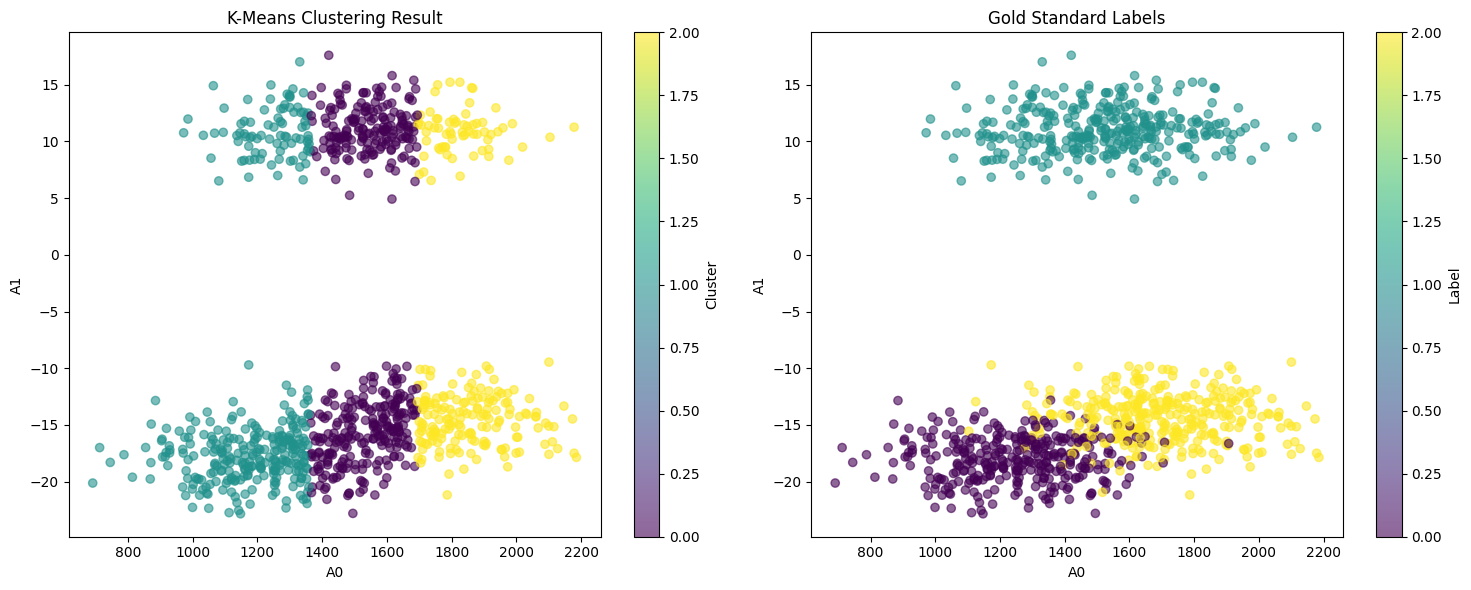

In [8]:
# Visualize the clustering results
if X.shape[1] >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot predicted clusters
    scatter1 = axes[0].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_km, cmap='viridis', alpha=0.6)
    axes[0].set_xlabel(X.columns[0])
    axes[0].set_ylabel(X.columns[1])
    axes[0].set_title('K-Means Clustering Result')
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')
    
    # Plot gold standard
    scatter2 = axes[1].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis', alpha=0.6)
    axes[1].set_xlabel(X.columns[0])
    axes[1].set_ylabel(X.columns[1])
    axes[1].set_title('Gold Standard Labels')
    plt.colorbar(scatter2, ax=axes[1], label='Label')
    
    plt.tight_layout()
    plt.show()

## 4. Remap Cluster Labels to Match Gold Standard

Each label in y_km must be remapped to the best matching label in y.
For each cluster in y_km, find the most frequent label in y.

In [9]:
# Create mapping from y_km clusters to y labels
# For each cluster in y_km, find the most frequent label in y
mapping = {}

for cluster_id in np.unique(y_km):
    # Get indices where y_km == cluster_id
    mask = y_km == cluster_id
    # Find most frequent label in y for this cluster
    most_frequent = mode(y[mask], keepdims=True).mode[0]
    mapping[cluster_id] = most_frequent
    print(f"Cluster {cluster_id} -> Label {most_frequent}")

print(f"\nMapping dictionary: {mapping}")

Cluster 0 -> Label 1
Cluster 1 -> Label 0
Cluster 2 -> Label 2

Mapping dictionary: {np.int32(0): np.int64(1), np.int32(1): np.int64(0), np.int32(2): np.int64(2)}


In [10]:
# Apply remapping
y_km_remapped = np.array([mapping[label] for label in y_km])

print("Remapped cluster distribution:")
print(pd.Series(y_km_remapped).value_counts().sort_index())
print("\nGold standard distribution:")
print(y.value_counts().sort_index())

Remapped cluster distribution:
0    346
1    423
2    231
Name: count, dtype: int64

Gold standard distribution:
y
0    334
1    333
2    333
Name: count, dtype: int64


## 5. Produce Confusion Matrix

Compare remapped predictions (y_km_remapped) with gold standard (y)

In [11]:
# Compute confusion matrix
cm = confusion_matrix(y, y_km_remapped)

print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"\nClustering Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[242  89   3]
 [ 85 182  66]
 [ 19 152 162]]

Clustering Accuracy: 0.5860


<Figure size 800x600 with 0 Axes>

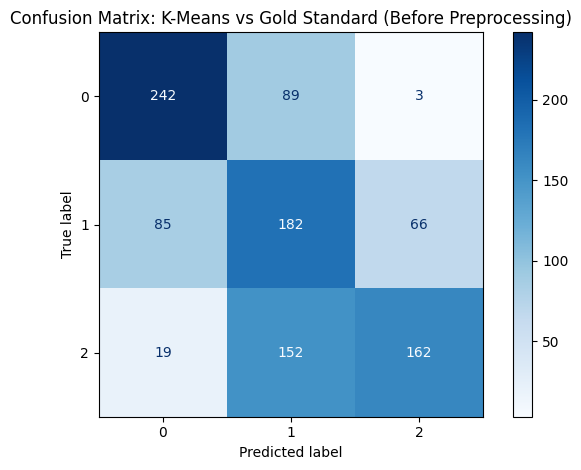

In [12]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: K-Means vs Gold Standard (Before Preprocessing)')
plt.tight_layout()
plt.show()

## 6. Apply Preprocessing and Re-evaluate

Apply preprocessing (scaling) and repeat the clustering process

In [13]:
# Check feature scales
print("Feature statistics before scaling:")
print(X.describe())

# Apply MinMaxScaler to normalize features to [0, 1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeature statistics after scaling:")
print(X_scaled_df.describe())

Feature statistics before scaling:
                A0           A1           A2
count  1000.000000  1000.000000  1000.000000
mean   1489.096297    -7.166652     0.505010
std     274.553828    13.077564     0.293416
min     690.679955   -22.833984     0.000412
25%    1295.382256   -17.161708     0.246973
50%    1495.200642   -14.249017     0.518429
75%    1676.991938     9.600518     0.766703
max    2185.753771    17.595486     0.999833

Feature statistics after scaling:
                A0           A1           A2
count  1000.000000  1000.000000  1000.000000
mean      0.534031     0.387523     0.504891
std       0.183639     0.323466     0.293586
min       0.000000     0.000000     0.000000
25%       0.404463     0.140301     0.246704
50%       0.538114     0.212344     0.518318
75%       0.659708     0.802249     0.766735
max       1.000000     1.000000     1.000000


In [14]:
# Test different k values with scaled data
silhouette_scores_scaled = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores_scaled.append(score)
    print(f"k={k}: Silhouette Score (scaled) = {score:.4f}")

k=2: Silhouette Score (scaled) = 0.4593
k=3: Silhouette Score (scaled) = 0.4279
k=4: Silhouette Score (scaled) = 0.4464
k=5: Silhouette Score (scaled) = 0.4202
k=6: Silhouette Score (scaled) = 0.3990
k=7: Silhouette Score (scaled) = 0.3630
k=8: Silhouette Score (scaled) = 0.3589
k=9: Silhouette Score (scaled) = 0.3542
k=10: Silhouette Score (scaled) = 0.3454


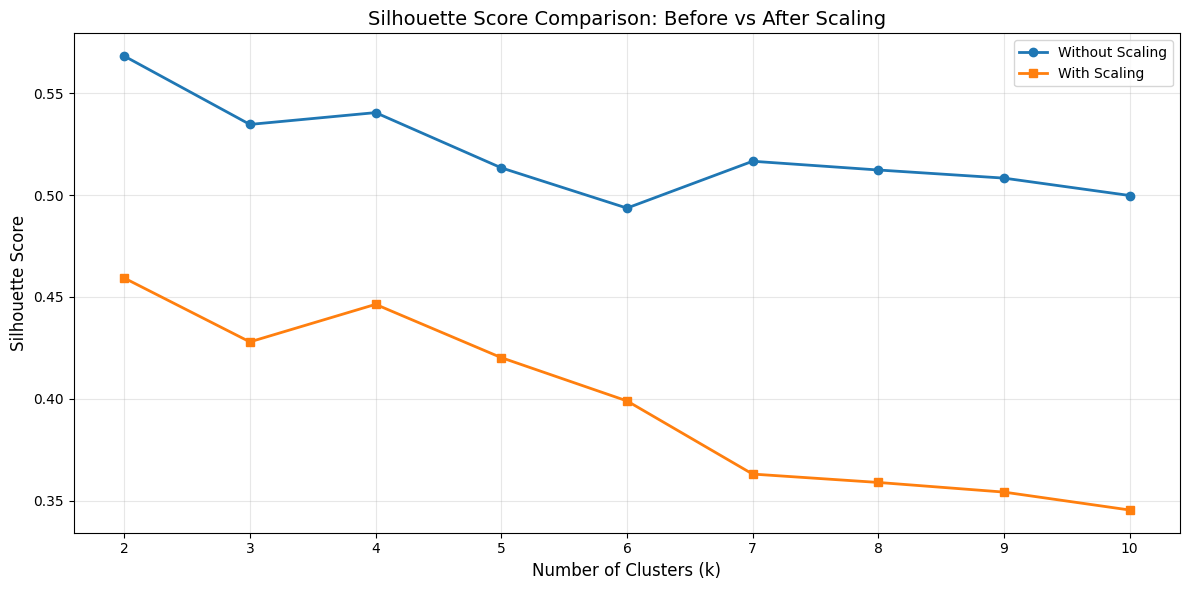

In [15]:
# Compare silhouette scores before and after scaling
plt.figure(figsize=(12, 6))
plt.plot(k_range, silhouette_scores, marker='o', label='Without Scaling', linewidth=2)
plt.plot(k_range, silhouette_scores_scaled, marker='s', label='With Scaling', linewidth=2)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score Comparison: Before vs After Scaling', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Fit final model with scaled data
kmeans_scaled = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
y_km_scaled = kmeans_scaled.fit_predict(X_scaled)

# Compute silhouette score
silhouette_scaled = silhouette_score(X_scaled, y_km_scaled)

print(f"Clustering with scaled data (k={chosen_k})")
print(f"Silhouette Score: {silhouette_scaled:.4f}")
print(f"Improvement: {silhouette_scaled - silhouette_final:+.4f}")

Clustering with scaled data (k=3)
Silhouette Score: 0.4279
Improvement: -0.1068


In [17]:
# Remap scaled clustering results
mapping_scaled = {}

for cluster_id in np.unique(y_km_scaled):
    mask = y_km_scaled == cluster_id
    most_frequent = mode(y[mask], keepdims=True).mode[0]
    mapping_scaled[cluster_id] = most_frequent
    print(f"Cluster {cluster_id} -> Label {most_frequent}")

# Apply remapping
y_km_scaled_remapped = np.array([mapping_scaled[label] for label in y_km_scaled])

Cluster 0 -> Label 2
Cluster 1 -> Label 1
Cluster 2 -> Label 0


In [18]:
# Compute confusion matrix for scaled data
cm_scaled = confusion_matrix(y, y_km_scaled_remapped)

print("Confusion Matrix (After Preprocessing):")
print(cm_scaled)

# Calculate accuracy
accuracy_scaled = np.trace(cm_scaled) / np.sum(cm_scaled)
print(f"\nClustering Accuracy: {accuracy_scaled:.4f}")
print(f"Improvement: {accuracy_scaled - accuracy:+.4f}")

Confusion Matrix (After Preprocessing):
[[176   0 158]
 [  0 333   0]
 [166   0 167]]

Clustering Accuracy: 0.6760
Improvement: +0.0900


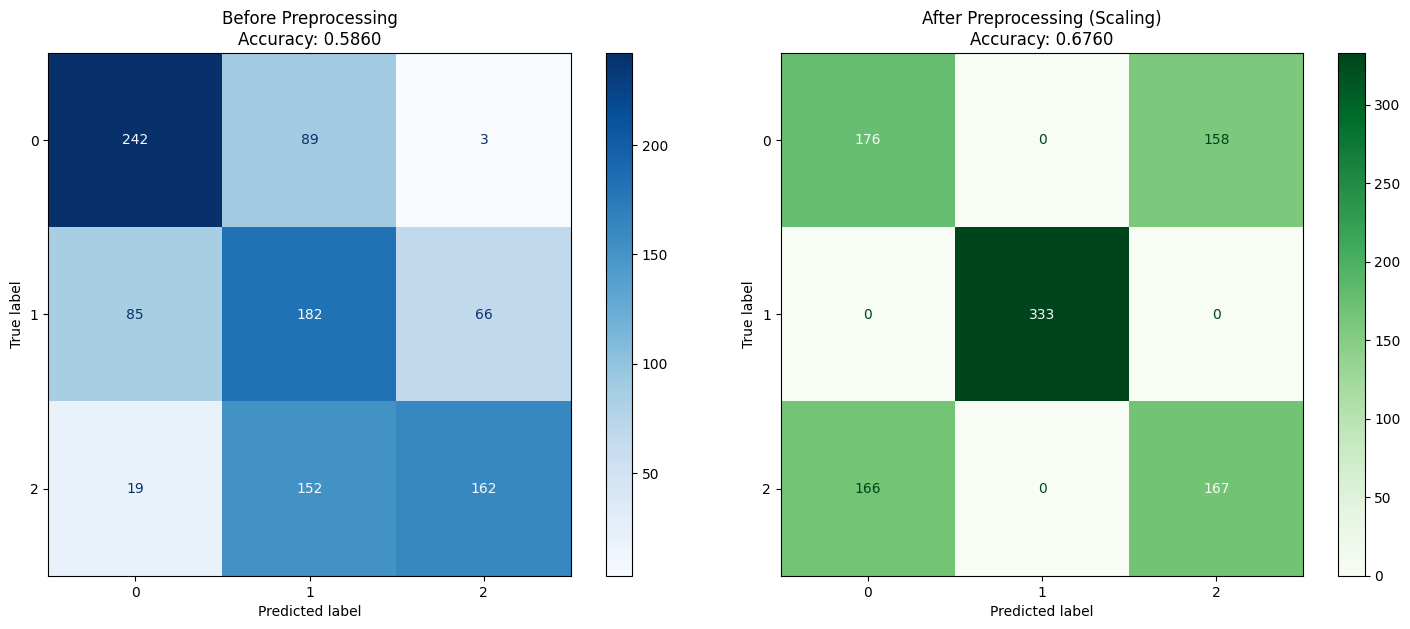

In [19]:
# Visualize both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before preprocessing
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Before Preprocessing\nAccuracy: {accuracy:.4f}')

# After preprocessing
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_scaled, display_labels=np.unique(y))
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'After Preprocessing (Scaling)\nAccuracy: {accuracy_scaled:.4f}')

plt.tight_layout()
plt.show()

### Final Comparison and Conclusions

**Results Summary:**

In [20]:
# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Accuracy'],
    'Without Preprocessing': [silhouette_final, accuracy],
    'With Preprocessing': [silhouette_scaled, accuracy_scaled],
    'Improvement': [
        silhouette_scaled - silhouette_final,
        accuracy_scaled - accuracy
    ]
})

print("\nPerformance Comparison:")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)


Performance Comparison:
          Metric  Without Preprocessing  With Preprocessing  Improvement
Silhouette Score               0.534718            0.427939    -0.106779
        Accuracy               0.586000            0.676000     0.090000


### Conclusions:

**Preprocessing Impact:**
- Feature scaling (MinMaxScaler) normalizes features to the same range
- This is crucial when features have different scales (e.g., A0 vs A1 vs A2)
- K-Means uses Euclidean distance, which is sensitive to feature scales
- Scaling ensures all features contribute equally to distance calculations

**Silhouette Score:**
- Higher silhouette score indicates better-defined clusters
- Improvement suggests preprocessing helped create more compact and separated clusters

**Accuracy:**
- Measures agreement between clustering and gold standard labels
- Improvement indicates preprocessing helped K-Means find clusters closer to true labels

**Best Practices:**
- Always visualize data before clustering (pairplot)
- Check feature scales and apply appropriate preprocessing
- Use silhouette score but also visual inspection for choosing k
- Remap cluster labels when comparing with ground truth
- Test multiple preprocessing strategies (MinMaxScaler, StandardScaler, etc.)

**Final Recommendation:**
The preprocessing step (feature scaling) is essential for this dataset and significantly improves clustering performance.